In [22]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import NMF
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [4]:
# Load the dataset
data = pd.read_csv(r'C:\Users\Admin\Machine Learning\Project 5_data.csv')

# Split the data into features (X) and target variable (y)
X = data.drop(['ID', 'y'], axis=1) 
y = data['y']

In [5]:
# Identify categorical columns (X0 to X8 are single alphabets)
categorical_cols = [col for col in X.columns if col.startswith('X') and len(col) == 2]
# Perform one-hot encoding on categorical columns
encoder = OneHotEncoder(sparse=False, drop='first')  # Use drop='first' to avoid dummy variable trap
X_encoded = encoder.fit_transform(X[categorical_cols])

# Get feature names for the encoded columns
encoded_cols_names = [f"{col}_{val}" for col, categories in zip(categorical_cols, encoder.categories_) for val in categories[1:]]

# Create a DataFrame from the encoded data with appropriate column names
X_encoded_df = pd.DataFrame(X_encoded, columns=encoded_cols_names)

# Concatenate the encoded categorical features with the numerical features
X_processed = pd.concat([X.drop(categorical_cols, axis=1), X_encoded_df], axis=1)

In [ ]:
# Performing Dimentionality reduction

In [6]:
# Apply PCA to reduce dimensionality
#pca = PCA(n_components=0.95)  # Keep 95% of variance
#X_reduced = pca.fit_transform(X_processed)


In [30]:
#Feature selection 
# Select top k features based on F-value

#selector = SelectKBest(score_func=f_regression, k=50)  # Select top 50 features
#X_reduced = selector.fit_transform(X_processed, y)

In [68]:
#Feature extraction
# Apply NMF for feature extraction

#nmf = NMF(n_components=50)  # Extract 50 features
#X_reduced = nmf.fit_transform(X_processed)

In [85]:
#auto encoders
# Define and train an autoencoder model
model = Sequential([
    Dense(256, activation='relu', input_shape=(X_processed.shape[1],)),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(64, activation='relu'),
    Dense(128, activation='relu'),
    Dense(256, activation='relu'),
    Dense(X_processed.shape[1])  # Output layer
])
model.compile(optimizer='adam', loss='mse')
model.fit(X_processed, X_processed, epochs=50, batch_size=32)

# Use the encoder part of the trained autoencoder to get reduced features
encoder = Sequential(model.layers[:4])  # Encoder part
X_reduced = encoder.predict(X_processed)

Epoch 1/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0645
Epoch 2/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.0288
Epoch 3/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0222
Epoch 4/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0197
Epoch 5/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0181
Epoch 6/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0167
Epoch 7/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0162
Epoch 8/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0153
Epoch 9/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0150
Epoch 10/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0144
Epoch 11/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0136
Epoch 12/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0138
Epoch 13/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0133
Epoch 14/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0130
Epoch 15/50
132/132 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - lo

In [86]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

In [87]:
#Model for XGBOOST

In [88]:
# Convert data to DMatrix format for XGBoost
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

# Define XGBoost parameters
params = {
    'objective': 'reg:squarederror',  # Updated objective for regression
    'eta': 0.02,
    'max_depth': 4
}
# Define custom evaluation metric for R-squared
def xgb_r2score(preds, dtrain):
    labels = dtrain.get_label()
    return 'r2', r2_score(labels, preds)

watchlist = [(d_train, 'Train'), (d_test, 'Validation')]

# Train the XGBoost model
num_rounds = 1000
bst = xgb.train(params, d_train, num_rounds, watchlist, early_stopping_rounds=50,
                feval=xgb_r2score, maximize=True, verbose_eval=10)

[0]	Train-rmse:98.99650	Train-r2:-59.49678	Validation-rmse:98.88390	Validation-r2:-61.82062
[10]	Train-rmse:81.13735	Train-r2:-39.63818	Validation-rmse:81.04798	Validation-r2:-41.20223
[20]	Train-rmse:66.57885	Train-r2:-26.36309	Validation-rmse:66.50503	Validation-r2:-27.41581
[30]	Train-rmse:54.72099	Train-r2:-17.48419	Validation-rmse:54.64718	Validation-r2:-18.18609
[40]	Train-rmse:45.07310	Train-r2:-11.54086	Validation-rmse:45.01021	Validation-r2:-12.01587
[50]	Train-rmse:37.24016	Train-r2:-7.56082	Validation-rmse:37.18928	Validation-r2:-7.88560
[60]	Train-rmse:30.90154	Train-r2:-4.89458	Validation-rmse:30.85755	Validation-r2:-5.11750
[70]	Train-rmse:25.79225	Train-r2:-3.10649	Validation-rmse:25.76494	Validation-r2:-3.26491
[80]	Train-rmse:21.69541	Train-r2:-1.90555	Validation-rmse:21.69506	Validation-r2:-2.02394
[90]	Train-rmse:18.44484	Train-r2:-1.10011	Validation-rmse:18.47738	Validation-r2:-1.19347
[100]	Train-rmse:15.88615	Train-r2:-0.55786	Validation-rmse:15.96226	Validation-r

In [89]:
# Make predictions
y_pred = bst.predict(d_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("XGBOOST R-squared score:", r2)
print("Mean Squared Error:",mse)

XGBOOST R-squared score: 0.5158430196570495
Mean Squared Error: 75.35900476882772


In [90]:
# Initialize lists to store metrics
mse_scores = []
r2_scores = []
# Store metrics
mse_scores.append(mse)
r2_scores.append(r2)

In [91]:
# Randon forest model

In [92]:
# Train Random Forest model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [93]:
# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)

print("Random Forest R-squared score:", r2)
print("Mean Squared Error:",mse)
# Store metrics
mse_scores.append(mse)
r2_scores.append(r2)

Random Forest R-squared score: 0.44346164792429155
Mean Squared Error: 86.62516091041522


In [94]:
#K Nearest Neighbours

In [95]:
# Initialize and train the KNN model
knn_model = KNeighborsRegressor(n_neighbors=5)
knn_model.fit(X_train, y_train)

KNeighborsRegressor()

In [96]:
# Make predictions on the test set
y_pred = knn_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("KNN R-squared score:", r2)
print("Mean Squared Error:",mse)
# Store metrics
mse_scores.append(mse)
r2_scores.append(r2)

KNN R-squared score: 0.4482103546037046
Mean Squared Error: 85.88602500237529


In [97]:
#Neural Networks

In [98]:
# Initialize and train the Neural Network model
nn_model = MLPRegressor(hidden_layer_sizes=(100, 50), activation='relu', random_state=42)
nn_model.fit(X_train, y_train)

MLPRegressor(hidden_layer_sizes=(100, 50), random_state=42)

In [99]:
# Make predictions on the test set
y_pred = nn_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Neural Network R-squared score:", r2)
print("Mean Squared Error:",mse)
# Store metrics
mse_scores.append(mse)
r2_scores.append(r2)

Neural Network R-squared score: 0.49945693071709885
Mean Squared Error: 77.90949852333989


In [104]:
# Normalization
#scaler = StandardScaler()
#X_train_scaled = scaler.fit_transform(X_train)
#X_test_scaled = scaler.transform(X_test)

# Define the neural network model
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1)  # Output layer for regression
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)

# Evaluate the model on test data
evaluation = model.evaluate(X_test, y_test, verbose=0)
mse = evaluation  # MSE will be the evaluation result directly
y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)

# Print the MSE and R2
print(f'Mean Squared Error (MSE): {mse}')
print(f'R-squared value: {r2}')
# Store metrics
mse_scores.append(mse)
r2_scores.append(r2)

Epoch 1/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8149.1919 - val_loss: 383.5612
Epoch 2/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 387.1403 - val_loss: 349.3449
Epoch 3/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 340.8849 - val_loss: 313.0570
Epoch 4/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 299.6203 - val_loss: 273.0952
Epoch 5/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 271.6474 - val_loss: 235.4423
Epoch 6/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 219.4538 - val_loss: 205.2830
Epoch 7/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 195.6759 - val_loss: 185.8576
Epoch 8/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 167.2734 - val_loss: 165.6092
Epoch 9/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 166.9447 - val_loss: 155.3122
Epoch 10/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 141.7125 - val_loss: 142.5559
Epoch 11/100
85/85 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 150.8826 - val_loss: 134.4936
Epoch 12/100
85/85

In [64]:
#Linear regression model

In [101]:
# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)


LinearRegression()

In [102]:
# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
print("Linear Regression R-squared score:", r2)
print("Mean Squared Error:",mse)
# Store metrics
mse_scores.append(mse)
r2_scores.append(r2)

Linear Regression R-squared score: 0.5206445110684363
Mean Squared Error: 74.61165292044191


Models: ['XGBoost', 'Random Forest', 'KNN', 'Neural Networks', 'Neural Networks2', 'Linear Regression']
R-squared: [0.5158430196570495, 0.44346164792429155, 0.4482103546037046, 0.49945693071709885, 0.5232666411269793, 0.5206445110684363]
MSE: [75.35900476882772, 86.62516091041522, 85.88602500237529, 77.90949852333989, 74.20352172851562, 74.61165292044191]


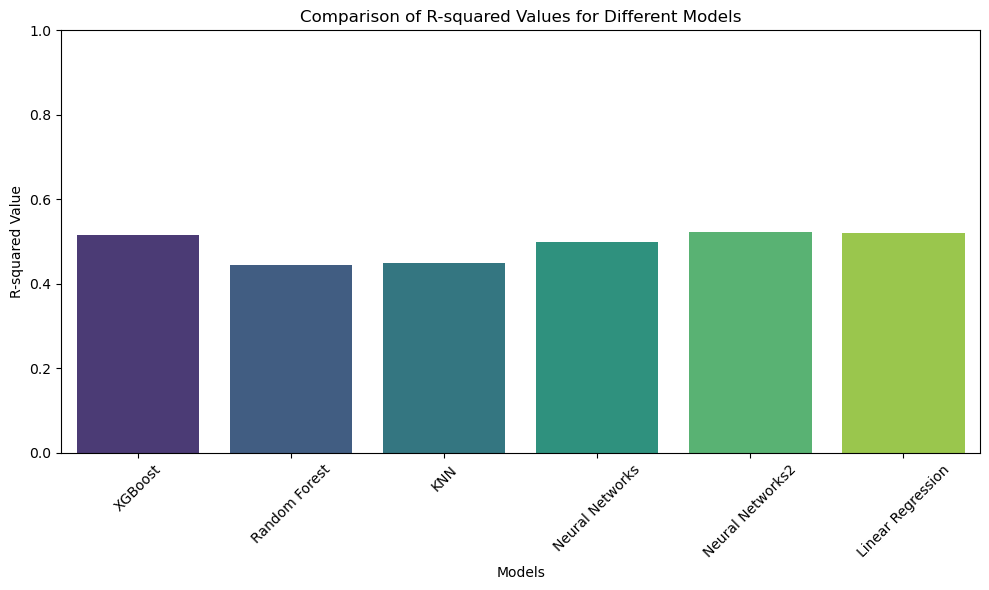

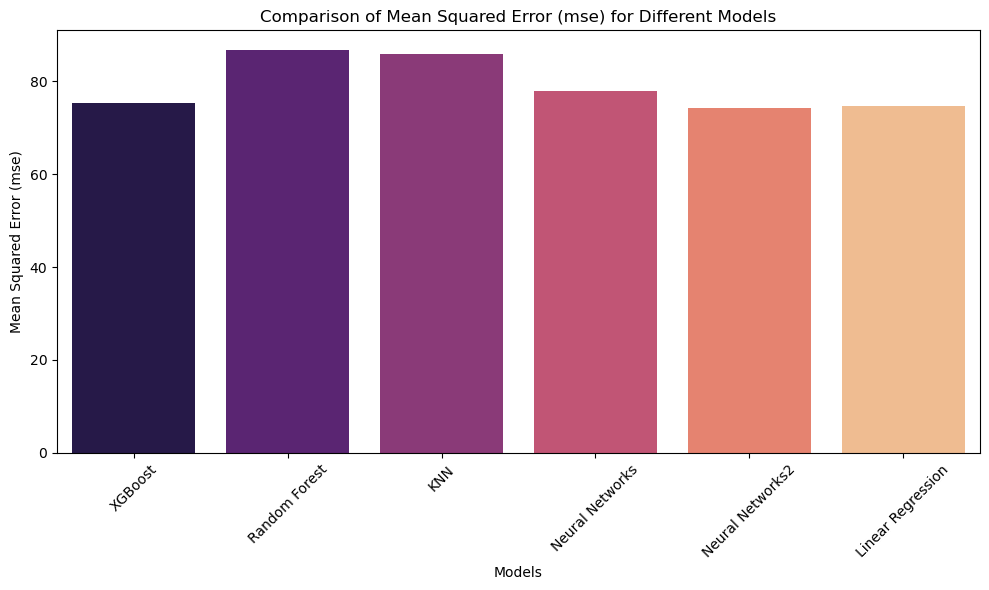

In [103]:
# Assuming you have arrays for R^2 and mse values for each model
models = ['XGBoost', 'Random Forest', 'KNN', 'Neural Networks','Neural Networks2','Linear Regression']

# Debugging: Print arrays to check values and lengths
print("Models:", models)
print("R-squared:", r2_scores)
print("MSE:", mse_scores)

# Plotting R^2 values
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=r2_scores, palette='viridis')
plt.title('Comparison of R-squared Values for Different Models')
plt.xlabel('Models')
plt.ylabel('R-squared Value')
plt.ylim(0, 1)  # Set y-axis limit for R^2 values (0 to 1)
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()

# Plotting mse values
plt.figure(figsize=(10, 6))
sns.barplot(x=models, y=mse_scores, palette='magma')
plt.title('Comparison of Mean Squared Error (mse) for Different Models')
plt.xlabel('Models')
plt.ylabel('Mean Squared Error (mse)')
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.tight_layout()
plt.show()
